In [46]:
import os.path as osp
import cv2
import numpy as np
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('/workspace/shared_workspace/deep-learning-models/models/vision/detection/')
from awsdet.datasets import transforms, utils

In [2]:
class CocoDataset(object):
    def __init__(self,
                 dataset_dir,
                 subset,
                 flip_ratio=0,
                 pad_mode='fixed',
                 mean=(0, 0, 0),
                 std=(1, 1, 1),
                 preproc_mode='caffe',
                 scale=(1024, 800),
                 train=False,
                 debug=False):
        '''Load a subset of the COCO dataset.
        
        Attributes
        ---
            dataset_dir: The root directory of the COCO dataset.
            subset: What to load (train, val).
            flip_ratio: Float. The ratio of flipping an image and its bounding boxes.
            pad_mode: Which padded method to use (fixed, non-fixed)
            mean: Tuple. Image mean.
            std: Tuple. Image standard deviation.
            scale: Tuple of two integers.
        '''

        if subset not in ['train', 'val']:
            raise AssertionError('subset must be "train" or "val".')

        self.coco = COCO("{}/annotations/instances_{}2017.json".format(
            dataset_dir, subset))

        # get the mapping from original category ids to labels
        self.cat_ids = self.coco.getCatIds()
        self.CLASSES = len(self.cat_ids)
        self.cat2label = {
            cat_id: i + 1
            for i, cat_id in enumerate(self.cat_ids)
        }

        self.img_ids, self.img_infos = self._filter_imgs()

        if debug:
            self.img_ids, self.img_infos = \
                self.img_ids[:50], self.img_infos[:50]

        self.image_dir = "{}/{}2017".format(dataset_dir, subset)

        self.flip_ratio = flip_ratio

        if pad_mode in ['fixed', 'non-fixed']:
            self.pad_mode = pad_mode
        elif subset == 'train':
            self.pad_mode = 'fixed'
        else:
            self.pad_mode = 'non-fixed'

        self.img_transform = transforms.ImageTransform(scale, mean, std,
                                                       pad_mode)
        self.bbox_transform = transforms.BboxTransform()
        self.train = train
        self.preproc_mode = preproc_mode

    def _filter_imgs(self, min_size=32):
        '''Filter images too small or without ground truths.
        
        Args
        ---
            min_size: the minimal size of the image.
        '''
        # Filter images without ground truths.
        all_img_ids = list(
            set([_['image_id'] for _ in self.coco.anns.values()]))
        # Filter images too small.
        img_ids = []
        img_infos = []
        for i in all_img_ids:
            info = self.coco.loadImgs(i)[0]

            ann_ids = self.coco.getAnnIds(imgIds=i)
            ann_info = self.coco.loadAnns(ann_ids)
            ann = self._parse_ann_info(ann_info)

            if min(info['width'],
                   info['height']) >= min_size and ann['labels'].shape[0] != 0:
                img_ids.append(i)
                img_infos.append(info)
        return img_ids, img_infos

    def _load_ann_info(self, idx):
        img_id = self.img_ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        ann_info = self.coco.loadAnns(ann_ids)
        return ann_info

    def _parse_ann_info(self, ann_info):
        '''Parse bbox annotation.
        
        Args
        ---
            ann_info (list[dict]): Annotation info of an image.
            
        Returns
        ---
            dict: A dict containing the following keys: bboxes, 
                bboxes_ignore, labels.
        '''
        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []

        for _, ann in enumerate(ann_info):
            if ann.get('ignore', False):
                continue
            x1, y1, w, h = ann['bbox']
            if ann['area'] <= 0 or w < 1 or h < 1:
                continue
            bbox = [y1, x1, y1 + h - 1, x1 + w - 1]
            if ann['iscrowd']:
                gt_bboxes_ignore.append(bbox)
            else:
                gt_bboxes.append(bbox)
                gt_labels.append(self.cat2label[ann['category_id']])

        if gt_bboxes:
            gt_bboxes = np.array(gt_bboxes, dtype=np.float32)
            gt_labels = np.array(gt_labels, dtype=np.int64)
        else:
            gt_bboxes = np.zeros((0, 4), dtype=np.float32)
            gt_labels = np.array([], dtype=np.int64)

        if gt_bboxes_ignore:
            gt_bboxes_ignore = np.array(gt_bboxes_ignore, dtype=np.float32)
        else:
            gt_bboxes_ignore = np.zeros((0, 4), dtype=np.float32)

        ann = dict(bboxes=gt_bboxes,
                   labels=gt_labels,
                   bboxes_ignore=gt_bboxes_ignore)

        return ann

    def __len__(self):
        return len(self.img_infos)


    def _tf_preprocessing(self, image):
        """
        [-1, 1] used by V2 implementations
        :param image:
        :return:
        """
        return image/127.0 - 1.0
 

    def _caffe_preprocessing(self, image, pixel_means):
        """
        BGR zero centered
        :param image:
        :return:
        """
        channels = cv2.split(image)
        for i in range(3):
            channels[i] -= pixel_means[i]
        return cv2.merge(channels)


    def __getitem__(self, idx):
        '''Load the image and its bboxes for the given index.
        
        Args
        ---
            idx: the index of images.
            
        Returns
        ---
            tuple: A tuple containing the following items: image, 
                bboxes, labels.
        '''
        img_info = self.img_infos[idx]
        ann_info = self._load_ann_info(idx)

        # load the image.
        bgr_img = cv2.imread(osp.join(self.image_dir, img_info['file_name']),
                         cv2.IMREAD_COLOR).astype(np.float32)
        if self.preproc_mode == 'tf':
            rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
            img = self._tf_preprocessing(rgb_img)
        elif self.preproc_mode == 'caffe':
            img = self._caffe_preprocessing(bgr_img, (103.939, 116.779, 123.68))
        else:
            raise NotImplementedError

        ori_shape = img.shape

        # Load the annotation.
        ann = self._parse_ann_info(ann_info)
        bboxes = ann['bboxes']
        labels = ann['labels']

        flip = True if np.random.rand() < self.flip_ratio else False

        # Handle the image
        img, img_shape, scale_factor = self.img_transform(img, flip)

        pad_shape = img.shape

        # Handle the annotation.
        bboxes, labels = self.bbox_transform(bboxes, labels, img_shape,
                                             scale_factor, flip)

        # Handle the meta info.
        img_meta_dict = dict({
            'ori_shape': ori_shape,
            'img_shape': img_shape,
            'pad_shape': pad_shape,
            'scale_factor': scale_factor,
            'flip': flip
        })

        img_meta = utils.compose_image_meta(img_meta_dict)
        if self.train:
            return img, img_meta, bboxes, labels
        return img, img_meta


    def get_categories(self):
        '''Get list of category names. 
        
        Returns
        ---
            list: A list of category names.
            
        Note that the first item 'bg' means background.
        '''
        return ['bg'] + [
            self.coco.loadCats(i)[0]["name"] for i in self.cat2label.keys()
        ]
    
class DataGenerator:

    def __init__(self, dataset, num_gpus=0, index=0, shuffle=False):
        self.dataset = dataset
        self.shuffle = shuffle
        self.gpu_index = index
        self.num_gpus = num_gpus
        if num_gpus > 0:
            self.num_examples = len(dataset) // num_gpus
        else:
            self.num_examples = len(dataset)
 
    def __call__(self):
        if self.num_gpus == 0:
            indices = np.arange(0, len(self.dataset))
        else:
            if self.dataset.train:
                indices = np.arange(0, len(self.dataset)) # ensure that each worker has a different seed
            else:
                indices = np.arange(self.gpu_index, len(self.dataset), self.num_gpus)
        while True:
            if self.shuffle:
                np.random.shuffle(indices)

            print('Starting new loop for GPU:', self.gpu_index)
            for img_idx in indices:
                # overfit hack  DEBUG
                # img_idx = self.gpu_index #DEBUG
                if self.dataset.train:
                    # print('Loading:', self.gpu_index, self.dataset.img_infos[img_idx]['file_name'])
                    img, img_meta, bboxes, labels = self.dataset[img_idx]
                    # print(self.gpu_index, img_meta)
                    yield img, img_meta, bboxes, labels
                else:
                    img, img_meta = self.dataset[img_idx]
                    yield img, img_meta


In [3]:
dataset_dir = '/workspace/shared_workspace/data/coco/coco/'
subset = 'train'

In [5]:
coco_dataset = CocoDataset(dataset_dir, subset, train=True)

loading annotations into memory...
Done (t=13.60s)
creating index...
index created!


In [64]:
idx=1
img, img_meta, bboxes, labels = coco_dataset[1]
img_info = coco_dataset.img_infos[idx]
ann_info = coco_dataset._load_ann_info(idx)
masks = np.array([coco_dataset.coco.annToMask(i) for i in ann_info])
masks = tf.expand_dims(masks, [3])
masks = tf.image.resize(masks, new_size)

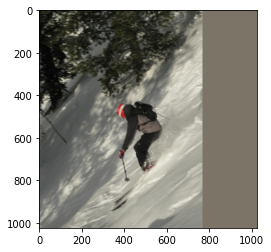

In [47]:
plt.imshow(tf.reverse((img + (103.939, 116.779, 123.68))/255., axis=[2]))

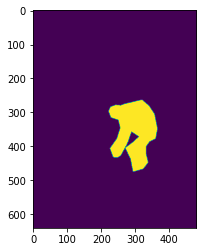

In [48]:
plt.imshow(masks[0])

In [53]:
new_size = img_meta[3:5]

<tf.Tensor: shape=(3, 1024, 768, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
   